In [118]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import statsmodels.api as sm

In [119]:
def compute_cumulative_growth(data):
    """
    Compute cumulative growth from a time series of returns or prices.
    """
    series = pd.Series(data)
    daily_change = series.pct_change()
    cumulative_growth = (1 + daily_change).cumprod() - 1
    cumulative_growth.fillna(0, inplace=True)
    return cumulative_growth

def compute_aggregate_returns(returns):
    """
    Aggregate the returns over time to get the cumulative sum.
    """
    cumulative_sum = np.cumsum(returns)
    cumulative_sum.fillna(0, inplace=True)
    return cumulative_sum

def format_timestamps_as_dates(data, col_name):
    """
    Convert timestamps to a human-readable datetime format.
    """
    if col_name in data.columns:
        data[col_name] = pd.to_datetime(data[col_name] / 1000, unit='s')
    return data

def visualize_cumulative_returns(cumulative_data, title):
    """
    Plot cumulative returns over time using seaborn and matplotlib.
    """
    if not isinstance(cumulative_data.index, pd.DatetimeIndex):
        cumulative_data.index = pd.to_datetime(cumulative_data.index)
    plt.figure(figsize=(14, 6))
    sns.lineplot(x=cumulative_data.index, y=cumulative_data.values)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.show()

def convert_timestamp_to_readable(timestamp):
    """
    Transform a millisecond timestamp into a human-readable string format.
    """
    return datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')


In [120]:

class CryptoStrategy:
    def __init__(self, price_data, coin_data, start_date, window_size):
        self.price_data = price_data
        self.coin_data = coin_data
        self.start_date = start_date
        self.window_size = window_size
        self.start_timestamp = self._convert_to_timestamp_each(start_date) - 3600000 * window_size
        print(self.start_timestamp)

        self.prices_df, self.coins_df = self._load_and_clean_data()
        self.returns_df = self.prices_df.pct_change()
        self.normalized_returns = self._normalize_returns()

        # Strategy thresholds
        self.buy_threshold = 1.4
        self.sell_threshold = 1.15
        self.close_buy_threshold = 0.75
        self.close_sell_threshold = 0.5

        # Initialize empty DataFrame for strategy actions
        self.strategy_actions = self.normalized_returns.copy()
        self.strategy_actions.loc[:, :] = np.nan

        self.cleaned_strategy = None
        self.score_list = None  # not used
        self.s_score_dict = None
        self.eigen_vectors = None
        self.top_coins_mapping = {}
        self.save_eigenvectors_to_csv = None

    def _convert_to_timestamp_each(self, date_str):
        """Convert a date string to a timestamp in milliseconds."""
        return int(pd.to_datetime(date_str).timestamp() * 1000)

    def _load_and_clean_data(self):
        """Load and preprocess the price and coin data."""
        prices = pd.read_csv(self.price_data)
        coins = pd.read_csv(self.coin_data)

        # Convert start times to timestamps
        timestamps = [self._convert_to_timestamp_each(ts) for ts in prices['startTime']]
        prices['timestamp'] = timestamps
        coins['timestamp'] = timestamps

        prices.drop(['time', 'startTime'], axis=1, inplace=True)
        coins.drop(['time', 'startTime'], axis=1, inplace=True)

        prices.set_index('timestamp', inplace=True)
        coins.set_index('timestamp', inplace=True)

        prices = prices.loc[self.start_timestamp:]
        coins = coins.loc[self.start_timestamp:]

        prices = prices.apply(pd.to_numeric, errors='coerce').fillna(method='ffill')

        return prices, coins

    def calculate_cumulative_returns(self, start_time, end_time):
        """Compute cumulative returns between two timestamps."""
        start_timestamp = self._convert_to_timestamp_each(start_time) if isinstance(start_time, str) else start_time
        end_timestamp = self._convert_to_timestamp_each(end_time) if isinstance(end_time, str) else end_time

        selected_data = self.prices_df[(self.prices_df.index >= start_timestamp) & (self.prices_df.index <= end_timestamp)]
        daily_returns = selected_data.pct_change()
        cumulative_returns = (1 + daily_returns).cumprod() - 1

        return cumulative_returns

    def _normalize_returns(self):
        """Calculate and normalize returns."""
        returns = self.prices_df.pct_change()
        normalized_returns = (returns - returns.mean()) / returns.std()
        return normalized_returns

    def compute_accumulated_returns(self, returns):
        """Compute accumulated returns given a list or series of returns."""
        accumulated = []
        compounded = 1
        for r in returns:
            compounded *= (1 + r)
            accumulated.append(compounded - 1)
        return accumulated

    def compute_compound_growth(self, returns):
        """Calculate compound growth from a series of returns."""
        if not isinstance(returns, pd.Series):
            returns_series = pd.Series(returns)
        else:
            returns_series = returns

        compound_growth = (1 + returns_series).cumprod()
        return compound_growth

    def find_common_values_in_rows(self, df):
        """Find common values across all rows of a DataFrame."""
        if df.empty:
            return []

        common_values = set(df.iloc[0])
        for index in range(1, len(df)):
            common_values.intersection_update(set(df.iloc[index]))

        return list(common_values)

    def columns_with_most_data(self, df, threshold=0.8):
        """Identify columns with non-NaN values above a threshold."""
        non_nan_ratio = df.notna().mean()
        columns_meeting_threshold = non_nan_ratio[non_nan_ratio >= threshold].index.tolist()
        return columns_meeting_threshold

    def normalize_columns(self, arr):
        """Normalize columns of a 2D array by their absolute sums."""
        col_sums = np.sum(np.abs(arr), axis=0)
        normalized_arr = arr / col_sums
        return normalized_arr

    def calculate_pca_and_factor_returns(self, correlation_matrix, returns_df):
        """Perform PCA and compute factor returns based on the correlation matrix."""
        pca = PCA(n_components=2)
        pca.fit(correlation_matrix)

        # Extract principal components and eigenvalues
        principal_components = pca.components_
        eigenvalues = pca.explained_variance_

        # Compute eigenportfolios
        eigenportfolios = principal_components.T / returns_df.std().values[:, None]

        # Calculate factor returns and eigen returns
        factor_returns = []
        eigen_returns = []
        for i in range(2):
            eigen_return = np.dot(eigenportfolios[:, i], returns_df.iloc[-1])
            eigen_returns.append(eigen_return)

            factor_return = np.sum(eigenportfolios[:, i] * returns_df, axis=1)
            factor_returns.append(factor_return)

        return tuple(factor_returns), eigenportfolios, eigen_returns

    def estimate_residuals_and_scores(self, top_coins_returns, F1, F2, index):
        """Estimate residuals and calculate scores for each coin."""
        regression_results = {}
        residuals = {}

        for token in top_coins_returns.columns:
            # Prepare regression inputs
            Y = top_coins_returns[token].values
            Y[0] = Y[1]  # Handle initial value if necessary

            X = sm.add_constant(np.column_stack((F1, F2)))

            # Perform regression
            model = sm.OLS(Y, X).fit()
            predictions = model.predict(X)

            # Calculate residuals
            epsilon = Y - predictions

            # Store results
            regression_results[token] = model.params
            residuals[token] = epsilon

        X_l, a_b_results = self.regress_residuals(residuals)
        score_list = {}
        action_list = {}

        for token in top_coins_returns.columns:
            k, m, sigma, sigma_eq = self.estimate_ou_parameters(
                a_b_results[token][0], a_b_results[token][1], residuals[token]
            )

            s_score = (np.sum(residuals[token]) - m) / sigma_eq
            score_list[token] = s_score

            if s_score < -1 * self.buy_threshold:
                action = 1
            elif s_score > self.sell_threshold:
                action = -1
            elif s_score < self.close_buy_threshold:
                action = "CS"
            elif s_score > -1 * self.close_sell_threshold:
                action = "CL"
            else:
                action = 0

            action_list[token] = action

        self.score_list = score_list

        return regression_results, residuals, X_l, a_b_results, score_list, action_list

    def regress_residuals(self, residuals):
        """Perform regression on residuals to calculate X_l and a, b parameters."""
        X_l_results = {}
        a_b_results = {}

        for token, epsilon in residuals.items():
            X_l = [np.sum(epsilon[max(0, l - self.window_size):l]) for l in range(1, self.window_size)]
            X_l_plus_1 = X_l[1:] + [np.sum(epsilon[-self.window_size:])]

            X = sm.add_constant(X_l[:-1])
            Y = X_l_plus_1[1:]

            model = sm.OLS(Y, X).fit()
            a_b_results[token] = (model.params[0], model.params[1])
            X_l_results[token] = X_l

        return X_l_results, a_b_results

    def estimate_ou_parameters(self, a, b, residuals):
        """Estimate parameters for the Ornstein-Uhlenbeck process."""
        delta_t = 1 / 8760
        k = -np.log(b) * 252
        m = a / (1 - b)
        variance_epsilon = np.var(residuals)
        sigma = np.sqrt(variance_epsilon * 2 * k / (1 - b**2))
        tolerance = 1e-10
        sigma_eq = np.sqrt(np.abs(variance_epsilon) / (1 - b**2 + tolerance))

        return k, m, sigma, sigma_eq

    def compute_correlation_matrices(self):
        """Compute correlation matrices and associated metrics over rolling windows."""
        correlation_matrices = {}
        factor_returns = {}
        a_b_results_dict = {}
        X_l_dict = {}
        residual_dict = {}
        s_score_dict = {}
        actions_dict = {}
        eigen_portfolio_dict = {}
        eigen_return_dict = {}
        topcoins_cal = {}

        for i in tqdm(range(self.window_size, self.normalized_returns.shape[0])):
            end_idx = i
            start_idx = end_idx - self.window_size

            window_returns = self.normalized_returns.iloc[start_idx:end_idx]
            end_time = self.normalized_returns.index[end_idx]
            
            top_coins = self.find_common_values_in_rows(self.coins_df.iloc[start_idx:end_idx])
            top_coins = self.columns_with_most_data(window_returns[top_coins])

            if 'ETH' not in top_coins:
                top_coins.append('ETH')

            self.top_coins_mapping[end_time] = top_coins

            if len(top_coins) > 0:
                top_coins_returns = window_returns[top_coins].dropna(axis=1, how='all')
                if not top_coins_returns.empty:
                    correlation_matrix = top_coins_returns.corr()
                    correlation_matrices[end_time] = correlation_matrix

                    top_coins_returns_filled = top_coins_returns.fillna(0)
                    two_factor_returns, eigen_portfolios, eigen_returns = self.calculate_pca_and_factor_returns(
                        correlation_matrix, top_coins_returns_filled
                    )

                    eigen_return_dict[end_time] = eigen_returns
                    factor_returns[end_time] = two_factor_returns
                    F1, F2 = two_factor_returns

                    regression_results, residuals, X_l, a_b_results, score_temp, action_temp = self.estimate_residuals_and_scores(
                        top_coins_returns, F1, F2, i
                    )

                    s_score_dict[end_time] = score_temp
                    a_b_results_dict[end_time] = a_b_results
                    actions_dict[end_time] = action_temp
                    eigen_portfolio_dict[end_time] = eigen_portfolios

                    self.strategy_actions.loc[end_time, top_coins_returns.columns] = action_temp
                    X_l_dict[end_time] = X_l

        df = self.strategy_actions
        columns_to_drop = df.columns[df.isnull().all()]
        df.drop(columns=columns_to_drop, inplace=True)

        self.cleaned_strategy = df
        self.s_score_dict = s_score_dict
        self.eigen_vectors = eigen_portfolio_dict

        return (
            correlation_matrices,
            factor_returns,
            a_b_results_dict,
            X_l_dict,
            s_score_dict,
            actions_dict,
            eigen_return_dict,
            self.top_coins_mapping,
        )

    def plot_eigen_portfolio_growth(self, eigen_data, start_ts, end_ts, component_index=0):
        """
        Visualize the cumulative growth of a specific eigen portfolio.

        Parameters:
        - eigen_data: Dictionary containing timestamps as keys and eigen returns as values.
        - start_ts: Starting timestamp to filter eigen returns.
        - end_ts: Ending timestamp to filter eigen returns.
        - component_index: Index of the principal component to visualize (default=0).
        """
        # Extract the chosen eigen portfolio's returns
        portfolio_returns = pd.DataFrame(eigen_data).transpose()[component_index]

        # Apply filtering by the time range
        filtered_returns = portfolio_returns[(portfolio_returns.index >= start_ts) & (portfolio_returns.index <= end_ts)]

        # Compute cumulative growth
        cumulative_growth = compute_aggregate_returns(filtered_returns)

        # Update index with readable timestamps
        cumulative_growth.index = [convert_timestamp_to_readable(ts) for ts in cumulative_growth.index]

        # Plot the results
        visualize_cumulative_returns(cumulative_growth, f"Principal Component {component_index + 1} Growth")



In [121]:
filenames=['coin_all_prices_full.csv','coin_universe_150K_40.csv']
strategy = CryptoStrategy(
    price_data=filenames[0],
    coin_data=filenames[1],
    start_date="2021-09-26 00:00:00",  # Replace with the actual start time in string format
    window_size=240  # Rolling window size in hours
)

1631750400000


/var/folders/7x/whnm27lx3wv4s2d_n2smbz_h0000gn/T/ipykernel_64908/1414109316.py:54: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices = prices.apply(pd.to_numeric, errors='coerce').fillna(method='ffill')
/Users/zhutianyi/anaconda3/envs/new_env/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [122]:
correlation_matrices,factor_returns,a_b_results_dict,X_l_dict,s_score_dict,actions_dict,eigen_return_dict,topcoins_cal=strategy.compute_correlation_matrices()

  0%|          | 0/8764 [00:00<?, ?it/s]/var/folders/7x/whnm27lx3wv4s2d_n2smbz_h0000gn/T/ipykernel_64908/1414109316.py:275: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CS' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.strategy_actions.loc[end_time, top_coins_returns.columns] = action_temp
/var/folders/7x/whnm27lx3wv4s2d_n2smbz_h0000gn/T/ipykernel_64908/1414109316.py:275: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CL' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.strategy_actions.loc[end_time, top_coins_returns.columns] = action_temp
/var/folders/7x/whnm27lx3wv4s2d_n2smbz_h0000gn/T/ipykernel_64908/1414109316.py:275: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future ver

# Task 1

In [123]:
starttime="2021-09-26 00:00:00"
endtime="2022-09-25 23:00:00"
timestart_ts=strategy._convert_to_timestamp_each(starttime)
timeend_ts=strategy._convert_to_timestamp_each(endtime)

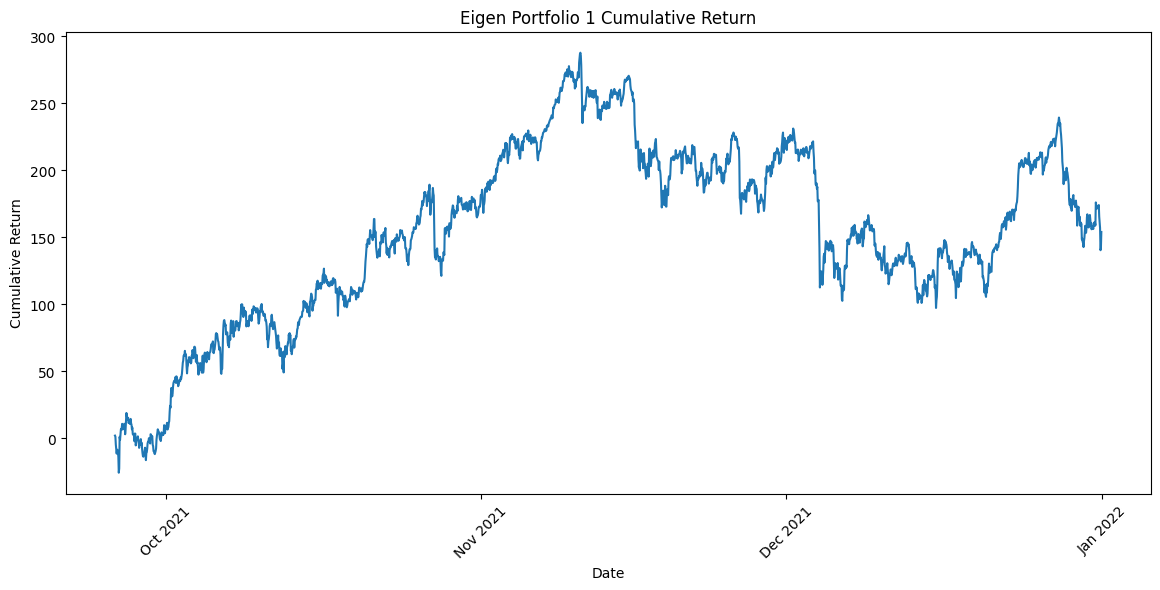

In [124]:
timestart_ts = strategy._convert_to_timestamp_each("2021-09-26 00:00:00")
timeend_ts = strategy._convert_to_timestamp_each("2021-12-31 23:59:59")
EV1_return = pd.DataFrame(eigen_return_dict).transpose()[0]
EV1_return = EV1_return[(EV1_return.index >= timestart_ts) & (EV1_return.index <= timeend_ts)]
EV1_returnCUMSUM = compute_aggregate_returns(EV1_return)
EV1_returnCUMSUM.index = [convert_timestamp_to_readable(v) for v in EV1_returnCUMSUM.index]
visualize_cumulative_returns(EV1_returnCUMSUM, 'Eigen Portfolio 1 Cumulative Return')


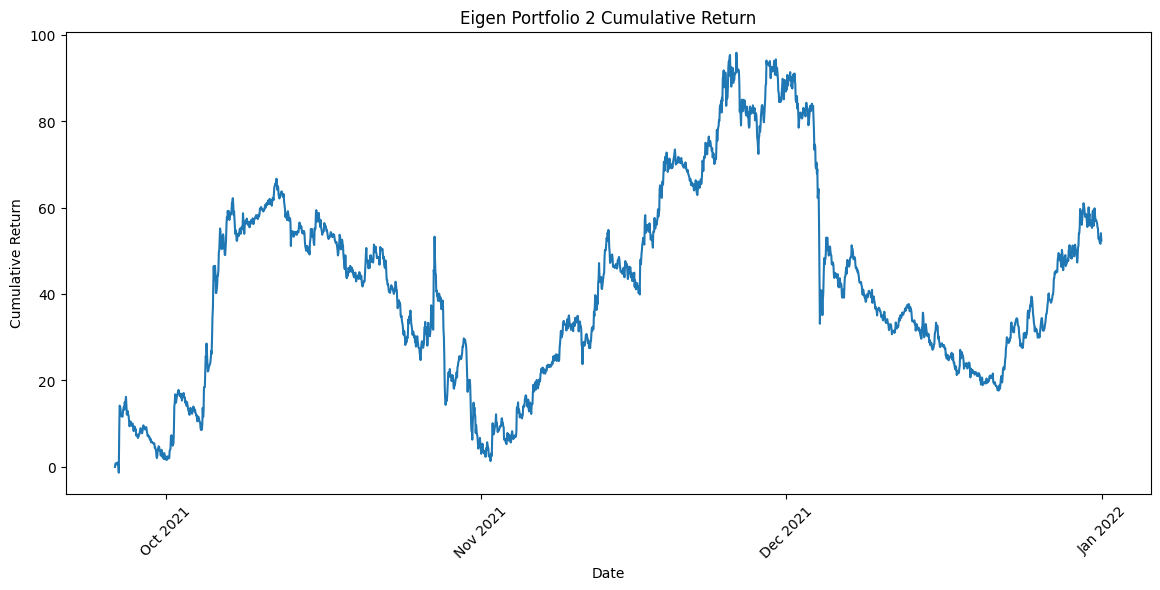

In [125]:
EV2_return = pd.DataFrame(eigen_return_dict).transpose()[1]
EV2_return = EV2_return[(EV2_return.index >= timestart_ts) & (EV2_return.index <= timeend_ts)]
EV2_returnCUMSUM = compute_aggregate_returns(EV2_return)
EV2_returnCUMSUM.index = [convert_timestamp_to_readable(v) for v in EV2_returnCUMSUM.index]
visualize_cumulative_returns(EV2_returnCUMSUM, 'Eigen Portfolio 2 Cumulative Return')


In [126]:
def calculate_and_plot_cumulative_return(strategy, asset_name, timestart_ts, timeend_ts, filename=None):
    """
    Calculate and plot the cumulative return for a specific asset.

    Parameters:
    - strategy: An instance of CryptoStrategy containing price data.
    - asset_name: Name of the asset (e.g., 'BTC', 'ETH').
    - timestart_ts: Start timestamp for filtering data.
    - timeend_ts: End timestamp for filtering data.
    - filename: Filename to save the plot. If None, the plot will not be saved.
    """
    try:
        # Extract the asset's price data within the given time range
        asset_prices = strategy.prices_df[asset_name]

        # Filter data within the provided time range
        asset_prices = asset_prices[(asset_prices.index >= timestart_ts) & (asset_prices.index <= timeend_ts)]

        # Ensure that the asset contains valid data for the range
        if asset_prices.empty:
            raise ValueError(f"No data available for asset {asset_name} in the specified time range.")

        # Calculate cumulative returns
        cumulative_returns = compute_cumulative_growth(asset_prices)

        # Convert timestamps to human-readable format
        cumulative_returns.index = [strategy._convert_to_timestamp_each(v) for v in cumulative_returns.index]

        # Plot cumulative returns
        visualize_cumulative_returns(cumulative_returns, f'{asset_name} Cumulative Return')

        # Save the plot if a filename is provided
        if filename:
            plt.savefig(filename)
            print(f"Plot saved to {filename}")

    except KeyError:
        print(f"Asset {asset_name} not found in the data.")
    except Exception as e:
        print(f"An error occurred: {e}")


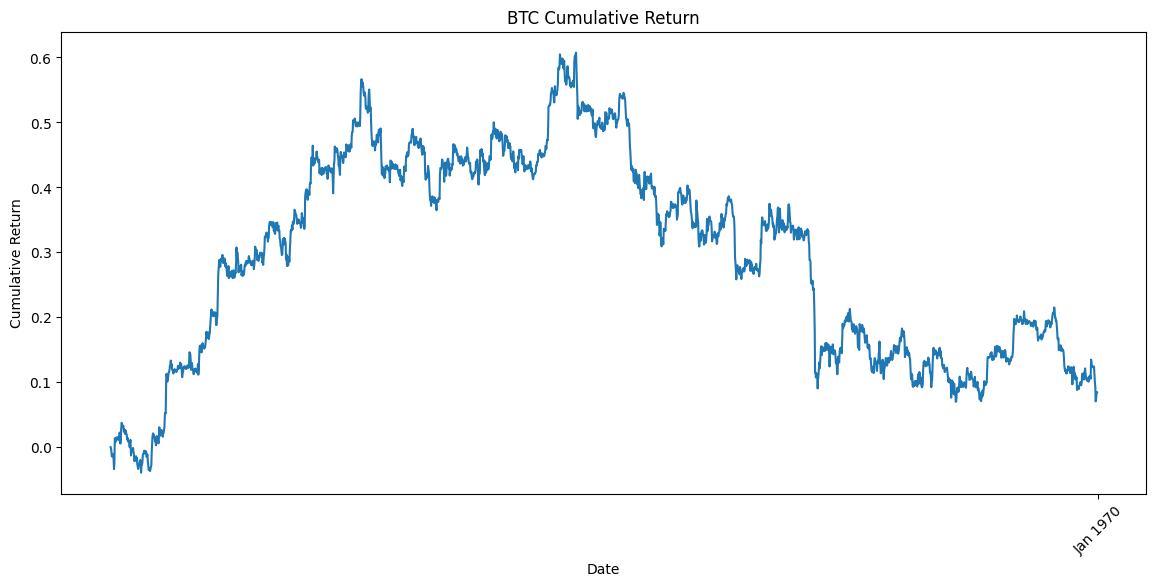

Plot saved to BTC_cumulative_returns.png


<Figure size 640x480 with 0 Axes>

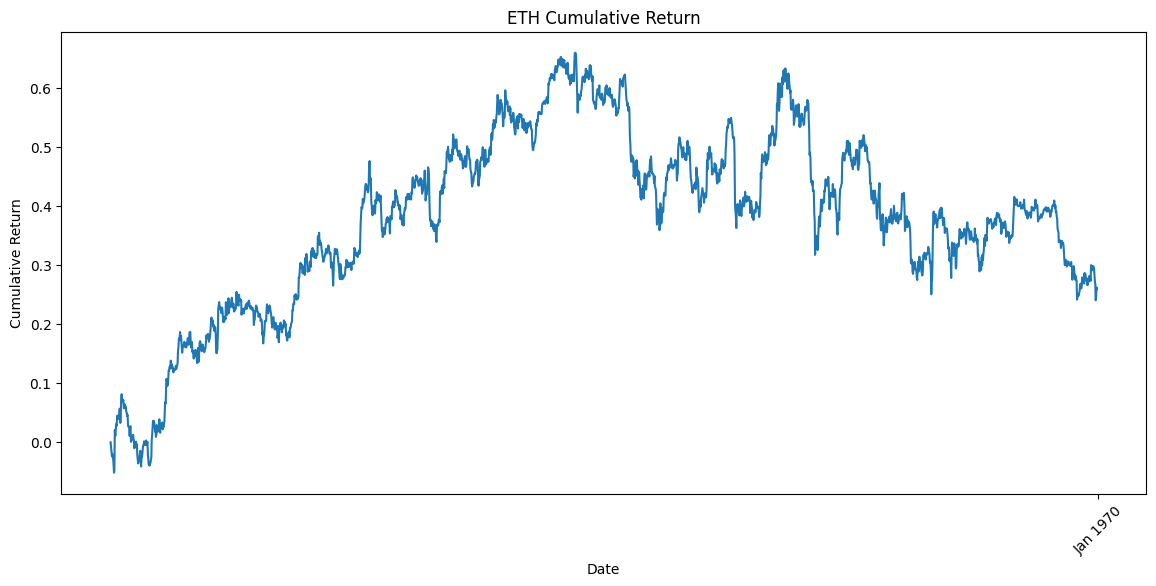

Plot saved to ETH_cumulative_returns.png


<Figure size 640x480 with 0 Axes>

In [127]:
timestart_ts = strategy._convert_to_timestamp_each("2021-09-26 00:00:00")
timeend_ts = strategy._convert_to_timestamp_each("2021-12-31 23:59:59")

calculate_and_plot_cumulative_return(
    strategy=strategy,
    asset_name='BTC',
    timestart_ts=timestart_ts,
    timeend_ts=timeend_ts,
    filename='BTC_cumulative_returns.png'
)

calculate_and_plot_cumulative_return(
    strategy=strategy,
    asset_name='ETH',
    timestart_ts=timestart_ts,
    timeend_ts=timeend_ts,
    filename='ETH_cumulative_returns.png'
)


In [128]:
def plot_combined_returns(asset_series, asset_labels, colors, timestart_ts, timeend_ts, filename=None):
    """
    Plot cumulative returns for multiple assets in a single chart.

    Parameters:
    - asset_series: List of Pandas Series for cumulative returns of each asset.
    - asset_labels: List of labels corresponding to the assets.
    - colors: List of colors for each asset line.
    - timestart_ts: Start timestamp for filtering data.
    - timeend_ts: End timestamp for filtering data.
    - filename: (Optional) Filename to save the plot.
    """
    fig, ax = plt.subplots(figsize=(15, 7))

    # Iterate through each asset series and plot
    for series, label, color in zip(asset_series, asset_labels, colors):
        filtered_series = series[(series.index >= timestart_ts) & (series.index <= timeend_ts)]
        ax.plot(pd.to_datetime(filtered_series.index), filtered_series, label=label, color=color)

    # Customize the plot
    ax.set_xlabel('Time (Month-Year)')
    ax.set_ylabel('Cumulative Return')
    ax.set_title('Cumulative Returns Comparison')
    ax.legend()

    # Format x-axis to display month and year
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)

    # Show and optionally save the plot
    plt.tight_layout()
    plt.show()

    if filename:
        plt.savefig(filename)
        print(f"Combined plot saved as {filename}")


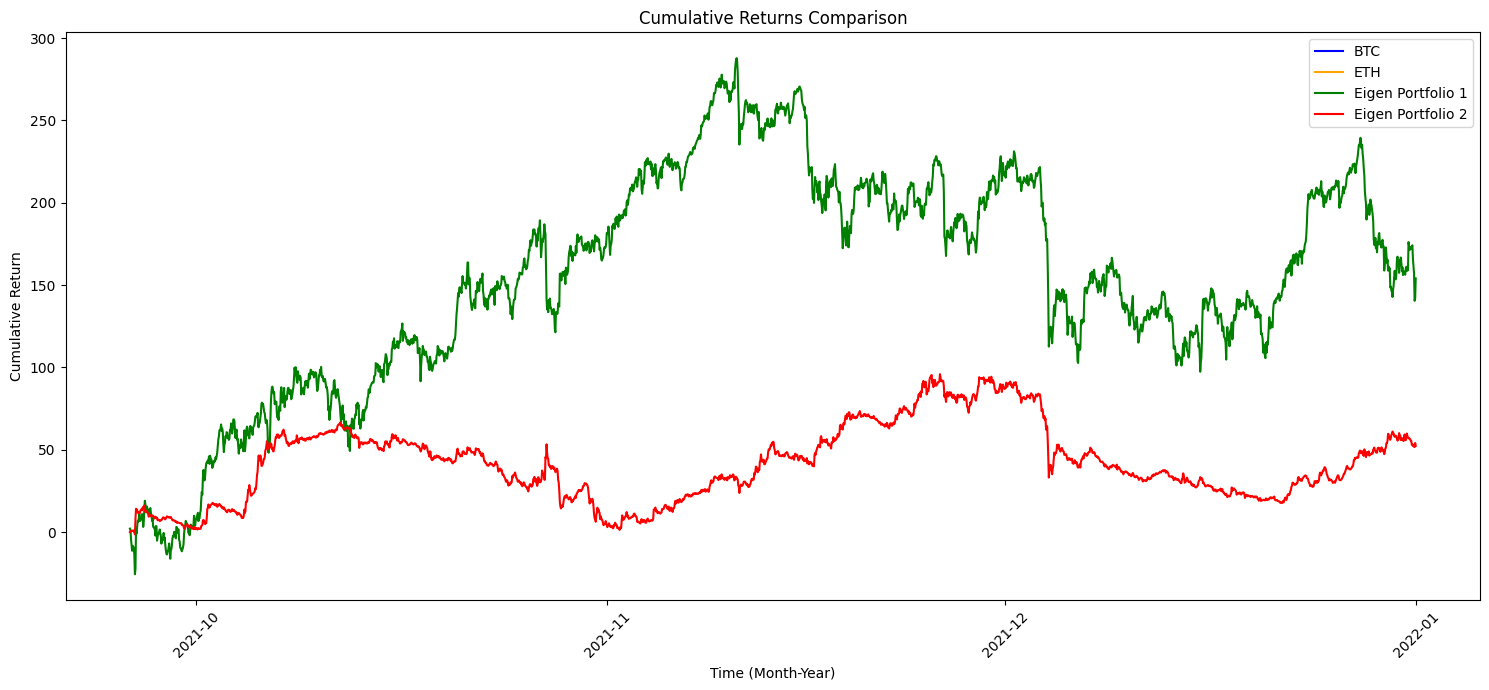

Combined plot saved as combined_cumulative_returns.png


<Figure size 640x480 with 0 Axes>

In [129]:
timestart_dt = pd.to_datetime(timestart_ts, unit='ms')
timeend_dt = pd.to_datetime(timeend_ts, unit='ms')
btc_prices = strategy.prices_df['BTC']
btc_prices.index = pd.to_datetime(btc_prices.index)

eth_prices = strategy.prices_df['ETH']
eth_prices.index = pd.to_datetime(eth_prices.index)

btc_series = compute_cumulative_growth(btc_prices[(btc_prices.index >= timestart_dt) & (btc_prices.index <= timeend_dt)])
eth_series = compute_cumulative_growth(eth_prices[(eth_prices.index >= timestart_dt) & (eth_prices.index <= timeend_dt)])

eigen1_series = EV1_returnCUMSUM
eigen1_series.index = pd.to_datetime(eigen1_series.index)
eigen1_series = eigen1_series[(eigen1_series.index >= timestart_dt) & (eigen1_series.index <= timeend_dt)]

eigen2_series = EV2_returnCUMSUM
eigen2_series.index = pd.to_datetime(eigen2_series.index)
eigen2_series = eigen2_series[(eigen2_series.index >= timestart_dt) & (eigen2_series.index <= timeend_dt)]

plot_combined_returns(
    asset_series=[btc_series, eth_series, eigen1_series, eigen2_series],
    asset_labels=['BTC', 'ETH', 'Eigen Portfolio 1', 'Eigen Portfolio 2'],
    colors=['blue', 'orange', 'green', 'red'],
    timestart_ts=timestart_dt,
    timeend_ts=timeend_dt,
    filename='combined_cumulative_returns.png'
)


In [130]:
def save_eigen_cumulative_returns_to_csv(eigen_return_dict, timestart_ts, timeend_ts, num_vec, filename):
    """
    Extract and save the cumulative returns of a specific eigen portfolio to a CSV file.

    Parameters:
    - eigen_return_dict: Dictionary containing eigen returns with timestamps as keys.
    - timestart_ts: Start timestamp for filtering data.
    - timeend_ts: End timestamp for filtering data.
    - num_vec: The eigen portfolio index to extract (0-based index).
    - filename: Name of the CSV file to save the data.
    """
    try:
        # Convert the eigen return dictionary to a DataFrame and select the specific eigen portfolio
        eigen_return = pd.DataFrame(eigen_return_dict).transpose()[num_vec]

        # Filter the data within the provided time range
        eigen_return = eigen_return[(eigen_return.index >= timestart_ts) & (eigen_return.index <= timeend_ts)]

        # Compute cumulative returns
        eigen_return_cumsum = compute_aggregate_returns(eigen_return)

        # Convert timestamps to readable format
        eigen_return_cumsum.index = [convert_timestamp_to_readable(v) for v in eigen_return_cumsum.index]

        # Save to CSV
        eigen_return_cumsum.to_csv(filename, header=["Cumulative Return"], index_label="Date")
        print(f"Eigen Portfolio {num_vec + 1} cumulative returns saved to {filename}")

    except Exception as e:
        print(f"An error occurred while saving cumulative returns: {e}")


In [131]:
timestart_ts = strategy._convert_to_timestamp_each("2021-09-26 00:00:00")
timeend_ts = strategy._convert_to_timestamp_each("2021-12-31 23:59:59")
num_vec = 0 
filename = "eigen_portfolio_1_cumulative_returns.csv"

save_eigen_cumulative_returns_to_csv(
    eigen_return_dict=eigen_return_dict,
    timestart_ts=timestart_ts,
    timeend_ts=timeend_ts,
    num_vec=num_vec,
    filename=filename
)


Eigen Portfolio 1 cumulative returns saved to eigen_portfolio_1_cumulative_returns.csv


In [132]:
filename = "eigen_portfolio_2_cumulative_returns.csv"
save_eigen_cumulative_returns_to_csv(
    eigen_return_dict=eigen_return_dict,
    timestart_ts=timestart_ts,
    timeend_ts=timeend_ts,
    num_vec=1,
    filename=filename
)

Eigen Portfolio 2 cumulative returns saved to eigen_portfolio_2_cumulative_returns.csv


In [133]:
def extract_eigenvector_to_csv(eigenvector_dict, vec_index):
    """
    Extract eigenvector weights for a specific eigenvalue index and save as DataFrame.

    Parameters:
    - eigenvector_dict: Dictionary containing eigenvectors for all timestamps.
    - vec_index: Index of the eigenvector to extract (1-based index).

    Returns:
    - DataFrame with eigenvector weights indexed by timestamps.
    """
    eigenvectors = eigenvector_dict

    # Initialize an empty dictionary to store eigenvector weights
    extracted_vectors = {}

    for timestamp, eigen_matrix in eigenvectors.items():
        if eigen_matrix is not None and len(eigen_matrix) > vec_index - 1:
            # Extract the specified eigenvector
            extracted_vectors[timestamp] = eigen_matrix[:, vec_index - 1]
        else:
            extracted_vectors[timestamp] = [np.nan] * len(eigen_matrix[0])

    # Convert to DataFrame with timestamps as rows
    df = pd.DataFrame.from_dict(extracted_vectors, orient='index')
    df.index.name = 'timestamp'
    return df


def save_eigenvector_to_csv(eigenvector_dict, filenames):
    """
    Save eigenvectors corresponding to the largest two eigenvalues into separate CSV files.

    Parameters:
    - eigenvector_dict: Dictionary containing eigenvectors.
    - filenames: List of filenames for saving (e.g., ['eigenvector_1.csv', 'eigenvector_2.csv']).
    """
    for i, filename in enumerate(filenames):
        df = extract_eigenvector_to_csv(eigenvector_dict, i + 1)
        df.to_csv(filename)
        print(f"Eigenvector {i + 1} saved to {filename}")



In [134]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


def compute_eigenvectors(strategy, top_tokens, n_components=2):
    """
    Compute eigenvectors for the largest eigenvalues of the correlation matrices.

    Parameters:
    - strategy: Instance of the CryptoStrategy class.
    - top_tokens: Dictionary mapping time to top tokens.
    - n_components: Number of eigenvectors to compute.

    Returns:
    - eigenvector_dict: A dictionary with keys for eigenvectors (e.g., vec1, vec2).
    """
    correlation_matrices, *_ = strategy.compute_correlation_matrices()
    eigenvector_dict = {f'vec{i + 1}': {} for i in range(n_components)}

    for timestamp, corr_matrix in correlation_matrices.items():
        if corr_matrix.shape[0] > 1:  # Ensure the matrix is valid
            pca = PCA(n_components=n_components)
            pca.fit(corr_matrix)
            eigenvectors = pca.components_
            eigenvectors = eigenvectors / np.sum(np.abs(eigenvectors), axis=1, keepdims=True)  # Normalize

            for i in range(n_components):
                eigenvector_dict[f'vec{i + 1}'][timestamp] = dict(zip(top_tokens[timestamp], eigenvectors[i]))

    return eigenvector_dict


def save_eigenvectors_to_csv(eigenvector_dict, filenames):
    """
    Save eigenvectors corresponding to the largest eigenvalues into separate CSV files.

    Parameters:
    - eigenvector_dict: Dictionary containing eigenvectors.
    - filenames: List of filenames for the eigenvector CSV files.
    """
    for key, filename in zip(eigenvector_dict.keys(), filenames):
        df = pd.DataFrame(eigenvector_dict[key]).T
        df.fillna(0, inplace=True)
        df.to_csv(filename)
        print(f"Saved {key} to {filename}")


def compute_and_plot_cumulative_returns(strategy, eigen_return_dict, timestart_ts, timeend_ts):
    """
    Plot cumulative returns for eigen-portfolios, BTC, and ETH.

    Parameters:
    - strategy: Instance of the CryptoStrategy class.
    - eigen_return_dict: Dictionary of eigenportfolio returns.
    - timestart_ts: Start timestamp for filtering data.
    - timeend_ts: End timestamp for filtering data.
    """
    # BTC Cumulative Return
    btc_prices = strategy.prices_df['BTC']
    btc_prices = btc_prices[(btc_prices.index >= timestart_ts) & (btc_prices.index <= timeend_ts)]
    btc_cum_returns = (1 + btc_prices.pct_change()).cumprod() - 1

    # ETH Cumulative Return
    eth_prices = strategy.prices_df['ETH']
    eth_prices = eth_prices[(eth_prices.index >= timestart_ts) & (eth_prices.index <= timeend_ts)]
    eth_cum_returns = (1 + eth_prices.pct_change()).cumprod() - 1

    # Eigen Portfolio 1
    EV1_return = pd.DataFrame(eigen_return_dict).transpose()[0]
    EV1_return = EV1_return[(EV1_return.index >= timestart_ts) & (EV1_return.index <= timeend_ts)]
    EV1_cum_returns = np.cumsum(EV1_return)

    # Eigen Portfolio 2
    EV2_return = pd.DataFrame(eigen_return_dict).transpose()[1]
    EV2_return = EV2_return[(EV2_return.index >= timestart_ts) & (EV2_return.index <= timeend_ts)]
    EV2_cum_returns = np.cumsum(EV2_return)

    # Plot
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=btc_cum_returns, label='BTC')
    sns.lineplot(data=eth_cum_returns, label='ETH')
    sns.lineplot(data=EV1_cum_returns, label='Eigen Portfolio 1')
    sns.lineplot(data=EV2_cum_returns, label='Eigen Portfolio 2')
    plt.title("Cumulative Returns: BTC, ETH, Eigen Portfolio 1, and Eigen Portfolio 2")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()


# Example Workflow
timestart_ts = strategy._convert_to_timestamp_each("2021-09-26 00:00:00")
timeend_ts = strategy._convert_to_timestamp_each("2021-12-31 23:59:59")

# 1. Compute Eigenvectors
top_tokens = strategy.top_coins_mapping
eigenvector_dict = compute_eigenvectors(strategy, top_tokens)

# 2. Save Eigenvectors to CSV
save_eigenvectors_to_csv(
    eigenvector_dict,
    filenames=["eigenvector_1.csv", "eigenvector_2.csv"]
)

  2%|▏         | 140/8764 [00:03<03:59, 36.02it/s]/var/folders/7x/whnm27lx3wv4s2d_n2smbz_h0000gn/T/ipykernel_64908/1414109316.py:219: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = np.sqrt(np.abs(variance_epsilon) / (1 - b**2 + tolerance))
  4%|▎         | 320/8764 [00:09<04:13, 33.32it/s]/var/folders/7x/whnm27lx3wv4s2d_n2smbz_h0000gn/T/ipykernel_64908/1414109316.py:219: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = np.sqrt(np.abs(variance_epsilon) / (1 - b**2 + tolerance))
  7%|▋         | 635/8764 [00:18<04:16, 31.74it/s]/var/folders/7x/whnm27lx3wv4s2d_n2smbz_h0000gn/T/ipykernel_64908/1414109316.py:219: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = np.sqrt(np.abs(variance_epsilon) / (1 - b**2 + tolerance))
 14%|█▎        | 1184/8764 [00:40<05:23, 23.43it/s]/var/folders/7x/whnm27lx3wv4s2d_n2smbz_h0000gn/T/ipykernel_64908/1414109316.py:219: RuntimeWarning: invalid value encountered in sqrt
  sigma_eq = np.sqrt(np.abs(variance_epsilon) /

Saved vec1 to eigenvector_1.csv
Saved vec2 to eigenvector_2.csv


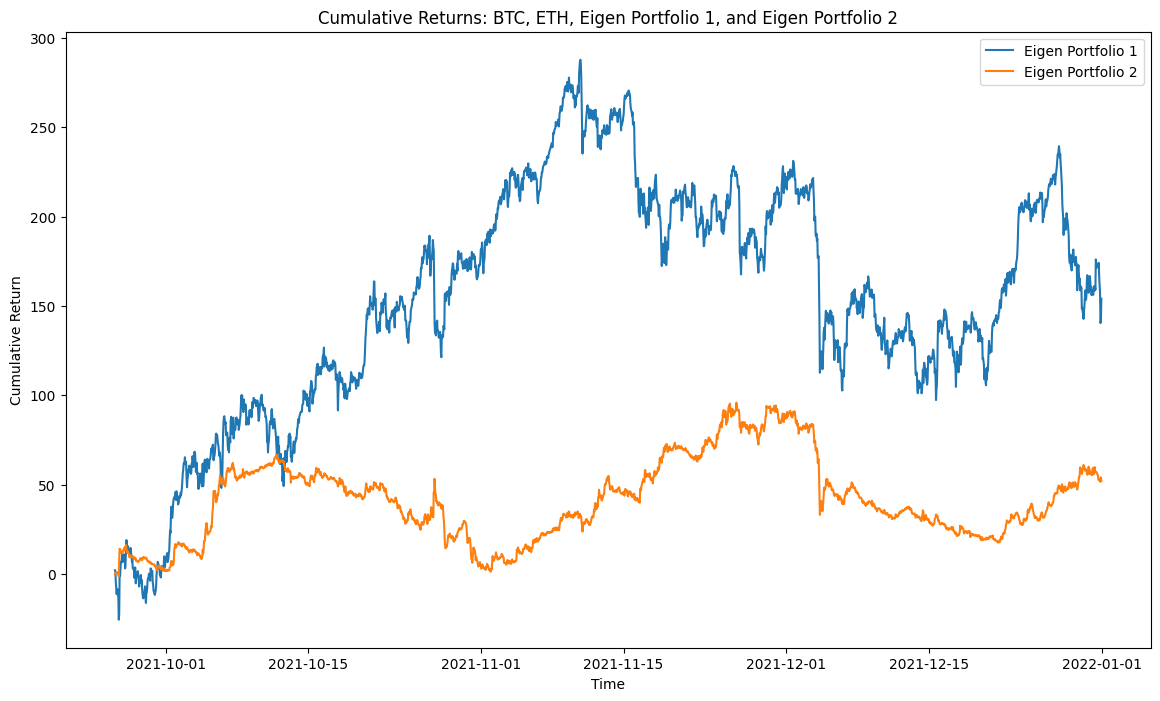

In [135]:
def compute_and_plot_cumulative_returns(strategy, eigen_return_dict, timestart_ts, timeend_ts):
    """
    Plot cumulative returns for eigen-portfolios, BTC, and ETH.

    Parameters:
    - strategy: Instance of the CryptoStrategy class.
    - eigen_return_dict: Dictionary of eigenportfolio returns.
    - timestart_ts: Start timestamp for filtering data.
    - timeend_ts: End timestamp for filtering data.
    """
    # Convert timestamps to datetime64
    timestart_dt = pd.to_datetime(timestart_ts, unit='ms')
    timeend_dt = pd.to_datetime(timeend_ts, unit='ms')

    # BTC Cumulative Return
    btc_prices = strategy.prices_df['BTC']
    btc_prices.index = pd.to_datetime(btc_prices.index, unit='ms')
    btc_prices = btc_prices[(btc_prices.index >= timestart_dt) & (btc_prices.index <= timeend_dt)]
    btc_cum_returns = (1 + btc_prices.pct_change()).cumprod() - 1

    # ETH Cumulative Return
    eth_prices = strategy.prices_df['ETH']
    eth_prices.index = pd.to_datetime(eth_prices.index, unit='ms')
    eth_prices = eth_prices[(eth_prices.index >= timestart_dt) & (eth_prices.index <= timeend_dt)]
    eth_cum_returns = (1 + eth_prices.pct_change()).cumprod() - 1

    # Eigen Portfolio 1
    EV1_return = pd.DataFrame(eigen_return_dict).transpose()[0]
    EV1_return.index = pd.to_datetime(EV1_return.index, unit='ms')
    EV1_return = EV1_return[(EV1_return.index >= timestart_dt) & (EV1_return.index <= timeend_dt)]
    EV1_cum_returns = np.cumsum(EV1_return)

    # Eigen Portfolio 2
    EV2_return = pd.DataFrame(eigen_return_dict).transpose()[1]
    EV2_return.index = pd.to_datetime(EV2_return.index, unit='ms')
    EV2_return = EV2_return[(EV2_return.index >= timestart_dt) & (EV2_return.index <= timeend_dt)]
    EV2_cum_returns = np.cumsum(EV2_return)

    # Plot
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=btc_cum_returns, label='BTC')
    sns.lineplot(data=eth_cum_returns, label='ETH')
    sns.lineplot(data=EV1_cum_returns, label='Eigen Portfolio 1')
    sns.lineplot(data=EV2_cum_returns, label='Eigen Portfolio 2')
    plt.title("Cumulative Returns: BTC, ETH, Eigen Portfolio 1, and Eigen Portfolio 2")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.show()


# Example Workflow
timestart_ts = strategy._convert_to_timestamp_each("2021-09-26 00:00:00")
timeend_ts = strategy._convert_to_timestamp_each("2021-12-31 23:59:59")

# Call the plot function
compute_and_plot_cumulative_returns(strategy, eigen_return_dict, timestart_ts, timeend_ts)


# Task 2

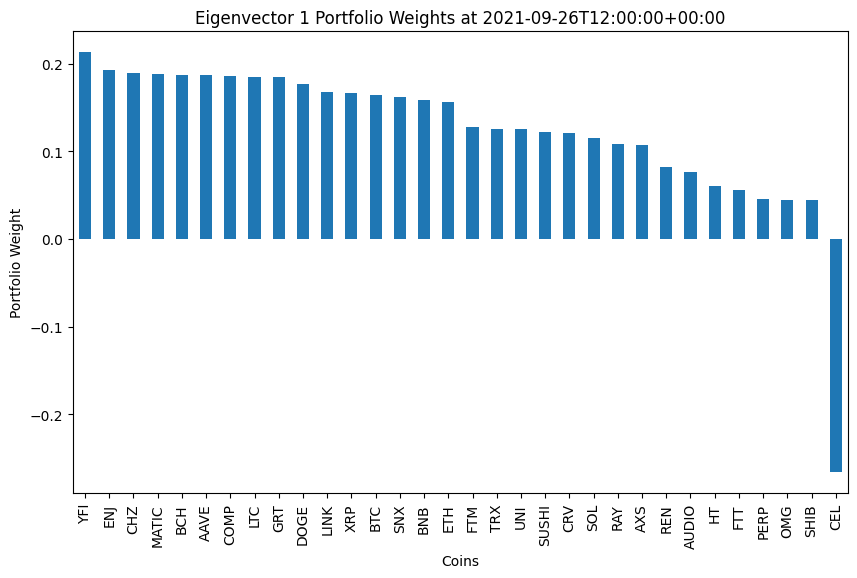

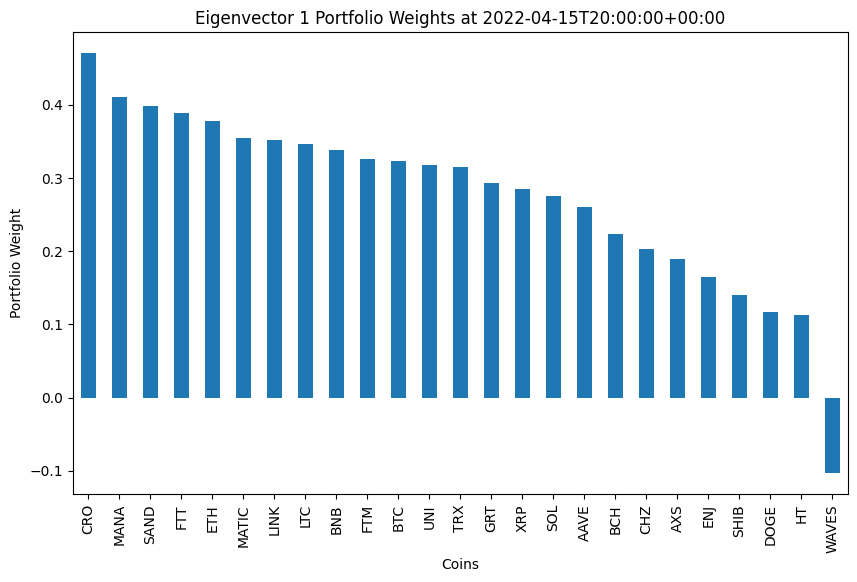

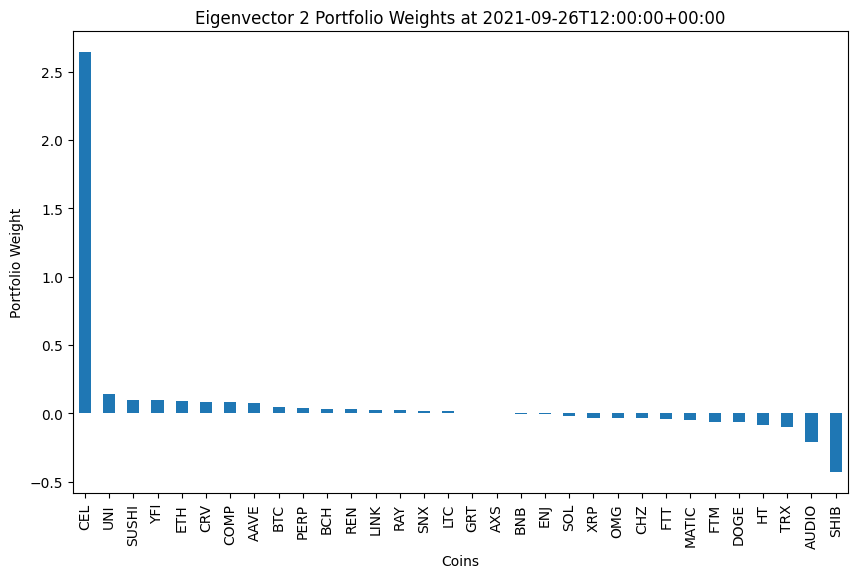

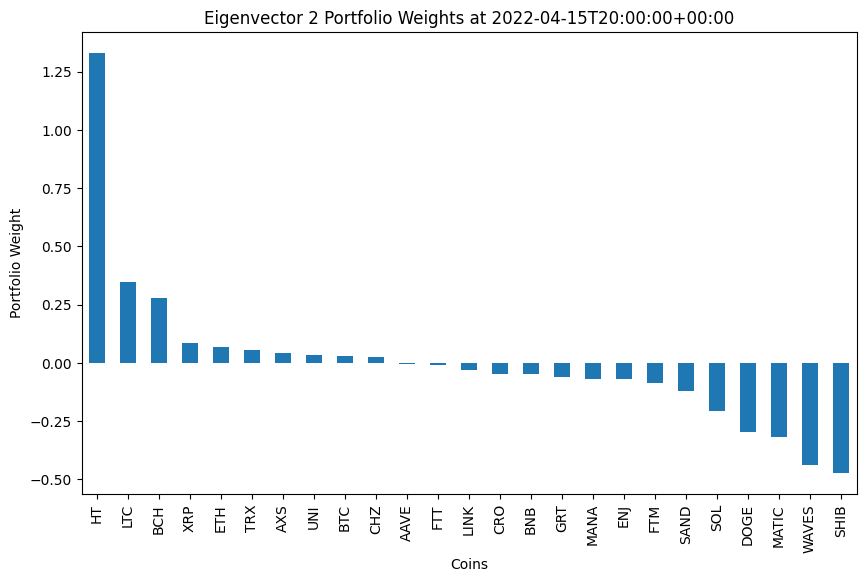

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_eigenweight(eigenvector_dict, top_coins_mapping, target_timestamp, eigenvector_index):
    """
    Plot the eigen-portfolio weights for the specified timestamp and eigenvector index.

    Parameters:
    - eigenvector_dict: Dictionary containing eigenvectors.
    - top_coins_mapping: Dictionary mapping timestamps to top coin names.
    - target_timestamp: Target timestamp in string format (e.g., "2021-09-26T12:00:00+00:00").
    - eigenvector_index: Index of the eigenvector to plot (1-based).
    """
    # Convert target timestamp to milliseconds
    target_timestamp_ms = int(pd.to_datetime(target_timestamp).timestamp() * 1000)

    # Find the closest timestamp in eigenvector_dict
    closest_timestamp = min(eigenvector_dict.keys(), key=lambda ts: abs(ts - target_timestamp_ms))
    
    if closest_timestamp not in eigenvector_dict:
        raise ValueError(f"Closest timestamp {closest_timestamp} not found in eigenvector_dict. "
                         f"Available timestamps: {list(eigenvector_dict.keys())}")

    if closest_timestamp not in top_coins_mapping:
        raise ValueError(f"Closest timestamp {closest_timestamp} not found in top_coins_mapping. "
                         f"Available timestamps: {list(top_coins_mapping.keys())}")

    # Retrieve eigenvector and corresponding coin names
    eigenvector = np.array(eigenvector_dict[closest_timestamp])
    portfolio_weights = eigenvector[:, eigenvector_index - 1]  # Adjust for 0-based indexing
    coin_names = top_coins_mapping[closest_timestamp]

    # Create a sorted weight series
    weight_series = pd.Series(portfolio_weights, index=coin_names).sort_values(ascending=False)

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    weight_series.plot(kind="bar")
    plt.title(f"Eigenvector {eigenvector_index} Portfolio Weights at {target_timestamp}")
    plt.xlabel("Coins")
    plt.ylabel("Portfolio Weight")
    plt.show()


# Example usage
timestamp_1 = "2021-09-26T12:00:00+00:00"
timestamp_2 = "2022-04-15T20:00:00+00:00"

# Assuming strategy.eigen_vectors and strategy.top_coins_mapping are populated
plot_eigenweight(
    eigenvector_dict=strategy.eigen_vectors,  # Replace with your actual eigenvector data
    top_coins_mapping=strategy.top_coins_mapping,
    target_timestamp=timestamp_1,
    eigenvector_index=1
)

plot_eigenweight(
    eigenvector_dict=strategy.eigen_vectors,
    top_coins_mapping=strategy.top_coins_mapping,
    target_timestamp=timestamp_2,
    eigenvector_index=1
)

plot_eigenweight(
    eigenvector_dict=strategy.eigen_vectors,
    top_coins_mapping=strategy.top_coins_mapping,
    target_timestamp=timestamp_1,
    eigenvector_index=2
)

plot_eigenweight(
    eigenvector_dict=strategy.eigen_vectors,
    top_coins_mapping=strategy.top_coins_mapping,
    target_timestamp=timestamp_2,
    eigenvector_index=2
)



# Task 3

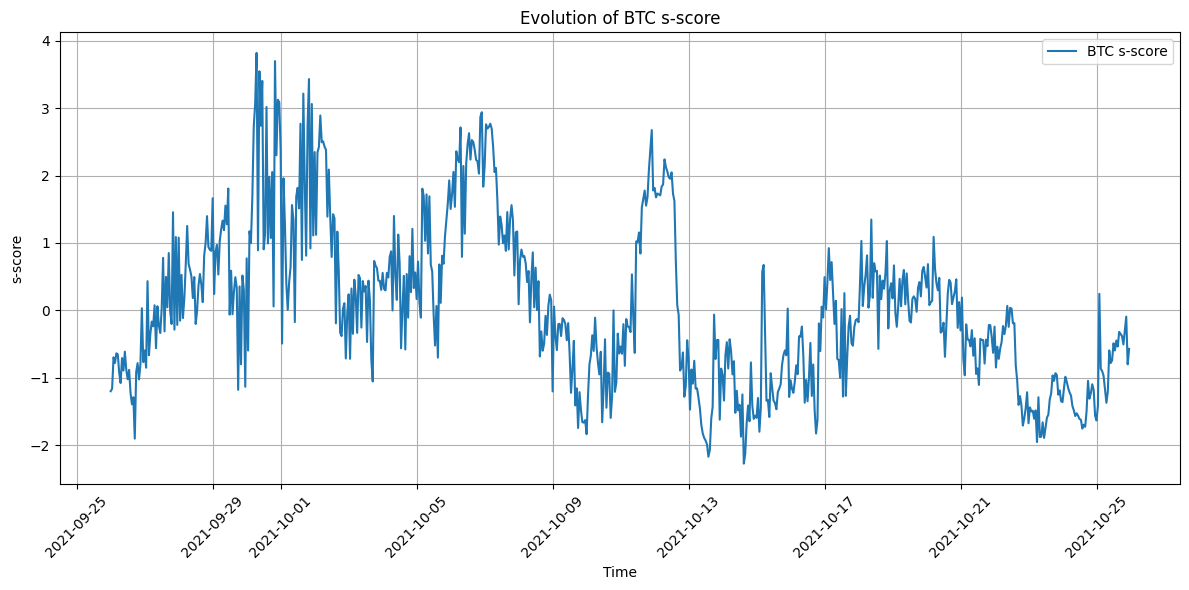

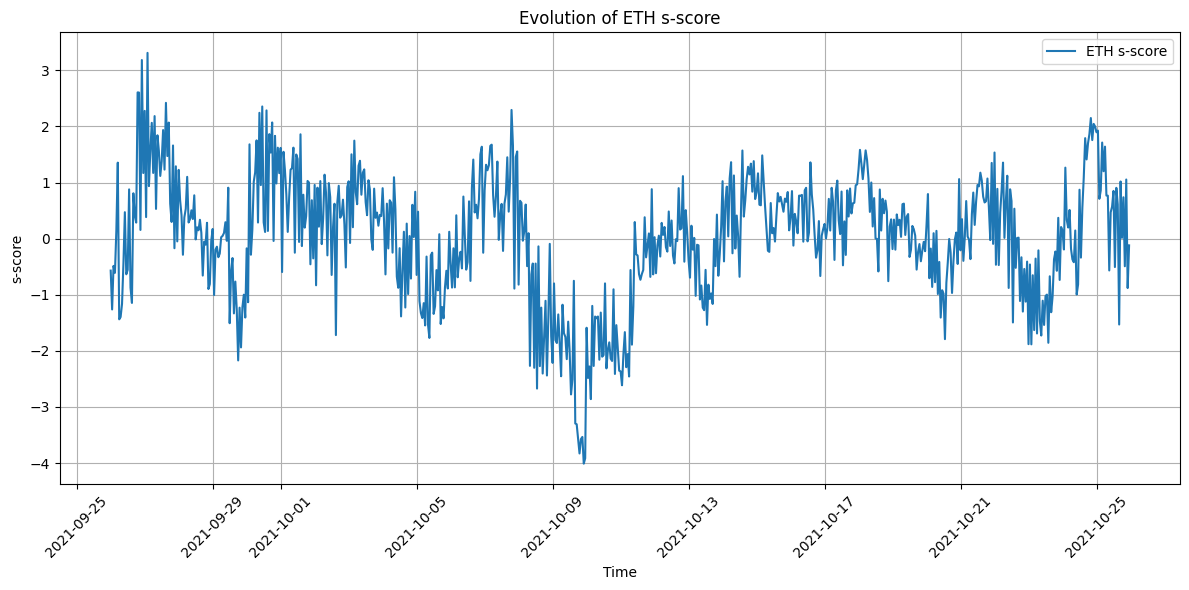

In [137]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_s_score_evolution(s_score_dict, coin, start_time, end_time):
    """
    Plot the evolution of the s-score for a specific coin within a given time range.

    Parameters:
    - s_score_dict: Dictionary containing s-scores for each timestamp.
    - coin: The coin to plot (e.g., 'BTC', 'ETH').
    - start_time: Start time in string format (e.g., "2021-09-26 00:00:00").
    - end_time: End time in string format (e.g., "2021-10-25 23:00:00").
    """
    # Convert start and end times to timestamps (milliseconds)
    start_ts = int(pd.to_datetime(start_time).timestamp() * 1000)
    end_ts = int(pd.to_datetime(end_time).timestamp() * 1000)

    # Filter s-score data for the specified time range
    filtered_scores = {
        timestamp: scores[coin]
        for timestamp, scores in s_score_dict.items()
        if start_ts <= timestamp <= end_ts and coin in scores
    }

    if not filtered_scores:
        raise ValueError(f"No data available for {coin} within the specified time range.")

    # Convert filtered_scores to a DataFrame for plotting
    timestamps = list(filtered_scores.keys())
    scores = list(filtered_scores.values())
    score_df = pd.DataFrame({'timestamp': timestamps, 's-score': scores})
    score_df['timestamp'] = pd.to_datetime(score_df['timestamp'], unit='ms')

    # Plot the s-score evolution
    plt.figure(figsize=(12, 6))
    plt.plot(score_df['timestamp'], score_df['s-score'], label=f'{coin} s-score')
    plt.title(f'Evolution of {coin} s-score')
    plt.xlabel('Time')
    plt.ylabel('s-score')
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Example usage
start_time = "2021-09-26 00:00:00"
end_time = "2021-10-25 23:00:00"

# Assuming strategy.s_score_dict contains the s-scores for all coins
plot_s_score_evolution(strategy.s_score_dict, coin='BTC', start_time=start_time, end_time=end_time)
plot_s_score_evolution(strategy.s_score_dict, coin='ETH', start_time=start_time, end_time=end_time)


# Task 4

In [244]:
def calculate_cumulative_return(strategy, token):
    """
    Calculate the cumulative return for a specific token based on strategy signals.

    Parameters:
    - strategy: CryptoStrategy instance.
    - token: The token name to calculate the cumulative return for.

    Returns:
    - cumulative_return: Final cumulative return.
    - return_list: List of cumulative returns over time.
    """
    cumulative_return = 0
    position = 0  # Positive for long, negative for short
    return_list = []

    # Extract returns and signals for the token
    returns = strategy.returns_df[token]
    signals = strategy.strategy_actions[token]

    for date in returns.index:
        signal = signals.loc[date] if date in signals.index else None
        daily_return = returns.loc[date] if date in returns.index else 0

        if signal == 1:  # Long
            position += 1
        elif signal == -1:  # Short
            position -= 1
        elif signal == "CS" and position < 0:  # Close short
            position = 0
        elif signal == "CL" and position > 0:  # Close long
            position = 0

        if position != 0:
            adjusted_return = daily_return * position
            cumulative_return += adjusted_return
        else:
            adjusted_return = 0

        return_list.append(cumulative_return)

    return cumulative_return, return_list


def calculate_compounded_cumulative_return(strategy, token):
    """
    Calculate the compounded cumulative return for a specific token.

    Parameters:
    - strategy: CryptoStrategy instance.
    - token: The token name to calculate the compounded return for.

    Returns:
    - net_return: Final compounded return.
    - return_list: List of compounded cumulative returns over time.
    """
    cumulative_return = 1  # Start with a base of 1 (100%)
    position = 0  # Positive for long, negative for short
    return_list = []

    # Extract returns and signals for the token
    returns = strategy.returns_df[token]
    signals = strategy.strategy_actions[token]

    for date in returns.index:
        signal = signals.loc[date] if date in signals.index else None
        daily_return = returns.loc[date] if date in returns.index else 0

        if signal == 1:  # Long
            position += 1
        elif signal == -1:  # Short
            position -= 1
        elif signal == "CS" and position < 0:  # Close short
            position = 0
        elif signal == "CL" and position > 0:  # Close long
            position = 0

        if position != 0:
            adjusted_return = (1 + daily_return) ** position
            cumulative_return *= adjusted_return
        else:
            adjusted_return = 1

        return_list.append(cumulative_return)

    net_return = cumulative_return - 1  # Convert to net compounded return
    return net_return, return_list


In [245]:
btc_cum_return, btc_cum_return_list = calculate_cumulative_return(strategy, "BTC")
eth_cum_return, eth_cum_return_list = calculate_cumulative_return(strategy, "ETH")

btc_compound_return, btc_compound_return_list = calculate_compounded_cumulative_return(strategy, "BTC")
eth_compound_return, eth_compound_return_list = calculate_compounded_cumulative_return(strategy, "ETH")

In [246]:
def calculate_compounded_cumulative_return(strategy, token):
    """
    Calculate the compounded cumulative return for a specific token.

    Parameters:
    - strategy: Instance of CryptoStrategy.
    - token: The token name for which to calculate the compounded cumulative return.

    Returns:
    - net_return: Final compounded return as a percentage.
    - return_list: List of compounded returns over time.
    """
    cumulative_return = 1.0  # Start with an initial investment value
    return_list = []  # To track the compounded return over time

    # Extract returns and signals
    daily_returns = strategy.returns_df[token]
    signals = strategy.strategy_actions[token]

    for date in daily_returns.index:
        signal = signals.loc[date] if date in signals.index else None
        daily_return = daily_returns.loc[date] if date in daily_returns.index else 0

        # Calculate the adjusted return based on the signal
        if signal == 1:  # Long
            adjusted_return = (1 + daily_return)
        elif signal == -1:  # Short
            adjusted_return = (1 - daily_return)
        else:
            adjusted_return = 1  # No position

        # Compound the return
        cumulative_return *= adjusted_return
        return_list.append(cumulative_return)

    net_return = (cumulative_return - 1) * 100  # Convert to percentage
    return net_return, return_list


def calculate_strategy_cumulative_return(strategy, token):
    """
    Calculate the cumulative return of the strategy for a specific token.

    Parameters:
    - strategy: Instance of CryptoStrategy.
    - token: The token name for which to calculate the cumulative return.

    Returns:
    - net_return: Final cumulative return as a percentage.
    - cumulative_returns_by_index: Dictionary with timestamps and corresponding returns.
    """
    cumulative_return = 0
    position = 0  # 0 means no position, 1 means long, -1 means short
    cumulative_returns_by_index = {}

    # Extract returns and signals
    daily_returns = strategy.returns_df[token]
    signals = strategy.strategy_actions[token]

    for date in daily_returns.index:
        signal = signals.loc[date] if date in signals.index else 0
        daily_return = daily_returns.loc[date] if date in daily_returns.index else 0

        # Update the position based on the signal
        if signal == 1:  # Go long
            position = 1
        elif signal == -1:  # Go short
            position = -1
        elif signal == "CS" and position < 0:  # Close short
            position = 0
        elif signal == "CL" and position > 0:  # Close long
            position = 0

        # Calculate the adjusted return based on the position
        if position != 0:  # If in a position, apply the return
            adjusted_return = daily_return * position
        else:
            adjusted_return = 0  # No position, no return

        cumulative_return += adjusted_return
        cumulative_returns_by_index[date] = cumulative_return

    net_return = cumulative_return * 100  # Convert to percentage
    return net_return, cumulative_returns_by_index


In [247]:
btc_cum_return, btc_cum_return_list = calculate_strategy_cumulative_return(strategy, "BTC")
eth_cum_return, eth_cum_return_list = calculate_strategy_cumulative_return(strategy, "ETH")

btc_compound_return, btc_compound_return_list = calculate_compounded_cumulative_return(strategy, "BTC")
eth_compound_return, eth_compound_return_list = calculate_compounded_cumulative_return(strategy, "ETH")

In [248]:
def calculate_daily_returns(strategy, token):
    """
    Calculate daily returns based on the strategy's signals for a specific token.

    Parameters:
    - strategy: Instance of CryptoStrategy.
    - token: The token name for which to calculate daily returns.

    Returns:
    - daily_returns_df: DataFrame with adjusted daily returns.
    """
    position = 0  # 0 means no position, 1 means long, -1 means short
    daily_returns_by_index = {}  # Dictionary to hold returns by index

    # Extract signals and returns
    signals = strategy.strategy_actions[token]
    daily_returns = strategy.returns_df[token]

    for date in signals.index:
        signal = signals.loc[date] if not pd.isna(signals.loc[date]) else 0
        daily_return = daily_returns.loc[date] if not pd.isna(daily_returns.loc[date]) else 0

        # Update the position based on the signal
        if signal == 1:  # Go long
            position = 1
        elif signal == -1:  # Go short
            position = -1
        elif signal == "CS" and position < 0:  # Close short
            position = 0
        elif signal == "CL" and position > 0:  # Close long
            position = 0

        # Calculate the adjusted return based on the position
        adjusted_daily_return = daily_return * position

        # Store the adjusted return
        daily_returns_by_index[date] = adjusted_daily_return

    # Convert the dictionary to a DataFrame
    daily_returns_df = pd.DataFrame(list(daily_returns_by_index.items()), columns=['Date', token])
    return daily_returns_df

def calculate_compounded_cumulative_returns(daily_returns):
    """
    Calculate the compounded cumulative returns over time.

    Parameters:
    - daily_returns: Series or DataFrame of daily returns.

    Returns:
    - net_return: Final compounded cumulative return as a percentage.
    - cumulative_returns_list: List of compounded returns over time.
    """
    compounded_return = 1.0  # Start with an initial value of 1 (100%)
    cumulative_returns_list = []  # List to store cumulative returns at each time step

    for daily_return in daily_returns:
        compounded_return *= (1 + daily_return)
        cumulative_returns_list.append(compounded_return)

    net_return = (compounded_return - 1) * 100  # Convert to percentage
    return net_return, cumulative_returns_list


In [249]:
def generate_trading_signals_csv(strategy, filename="trading_signals.csv"):
    """
    Save the trading signals for all tokens to a CSV file.

    Parameters:
    - strategy: Instance of CryptoStrategy.
    - filename: Name of the CSV file to save.
    """
    trading_signals_df = strategy.strategy_actions.copy()
    trading_signals_df.to_csv(filename)
    print(f"Trading signals saved to {filename}")


def plot_strategy_performance(strategy, tokens):
    hourly_returns = strategy.returns_df.mean(axis=1)
    
    hourly_returns = hourly_returns.replace([np.inf, -np.inf], np.nan).dropna()

    plt.figure(figsize=(10, 6))
    plt.hist(hourly_returns, bins=30, color='skyblue')
    plt.title("Histogram of Hourly Returns", fontsize=15)
    plt.xlabel("Returns", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

    plt.figure(figsize=(10, 6))
    for token in tokens:
        cumulative_returns = (1 + strategy.returns_df[token]).cumprod() - 1
        plt.plot(cumulative_returns, label=f"{token} Cumulative Return")
    plt.title("Cumulative Returns for Selected Tokens", fontsize=15)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Cumulative Returns", fontsize=12)
    plt.legend()
    plt.show()


Trading signals saved to trading_signals.csv


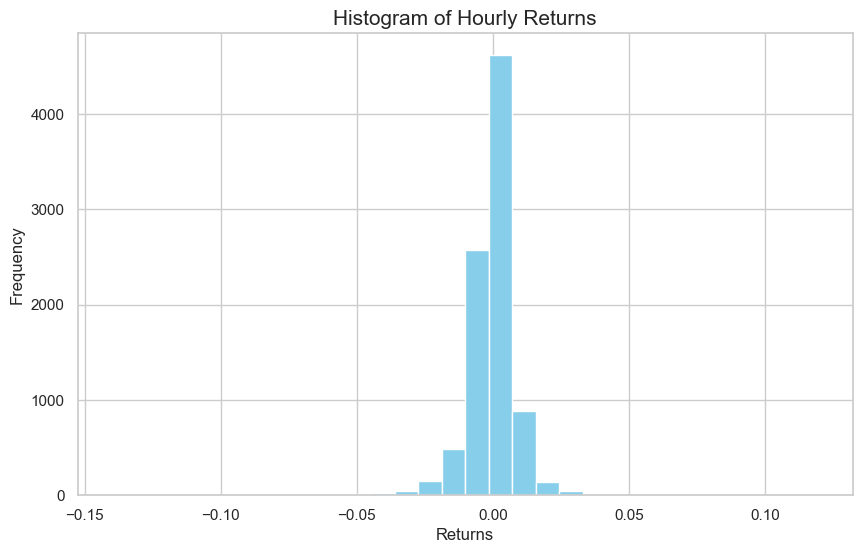

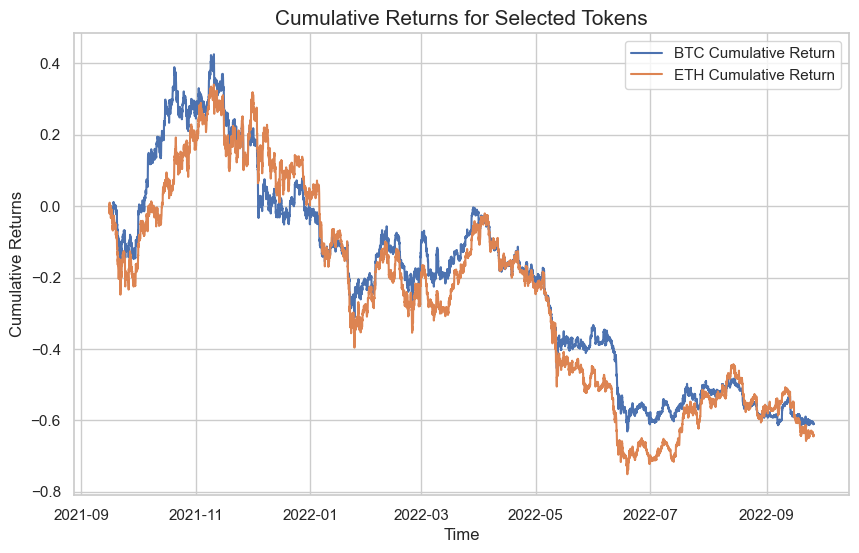

In [250]:
# Example Execution
generate_trading_signals_csv(strategy)

# Plot cumulative return curve and histogram for BTC and ETH
plot_strategy_performance(strategy, ["BTC", "ETH"])


In [254]:
# Extract signals and returns for the token
signals = strategy.strategy_actions[token]
daily_returns = strategy.returns_df[token]

# Ensure signals and daily_returns have aligned indices
signals = signals.reindex(daily_returns.index, fill_value=0)


In [255]:
daily_returns_by_index = {}  # Dictionary to hold returns by index
position = 0  # 0 means no position, 1 means long, -1 means short

for date in daily_returns.index:
    signal = signals.loc[date] if not pd.isna(signals.loc[date]) else 0
    daily_return = daily_returns.loc[date] if not pd.isna(daily_returns.loc[date]) else 0

    # Update the position based on the signal
    if signal == 1:  # Go long
        position = 1
    elif signal == -1:  # Go short
        position = -1
    elif signal == "CS" and position < 0:  # Close short
        position = 0
    elif signal == "CL" and position > 0:  # Close long
        position = 0

    # Calculate the adjusted return based on the position
    adjusted_daily_return = daily_return * position
    daily_returns_by_index[date] = adjusted_daily_return


In [258]:
daily_returns_by_index = {}  # 存储每日收益
position = 0  # 初始持仓：0 表示空仓，1 表示多头，-1 表示空头

# 遍历索引并计算调整后的每日收益
for date in daily_returns.index:
    # 获取信号和每日收益
    signal = signals.loc[date] if not pd.isna(signals.loc[date]) else 0
    daily_return = daily_returns.loc[date] if not pd.isna(daily_returns.loc[date]) else 0

    # 根据信号更新持仓
    if signal == 1:  # 多头
        position = 1
    elif signal == -1:  # 空头
        position = -1
    elif signal == "CS" and position < 0:  # 平空仓
        position = 0
    elif signal == "CL" and position > 0:  # 平多仓
        position = 0

    # 根据持仓调整每日收益
    adjusted_daily_return = daily_return * position

    # 存储调整后的收益
    daily_returns_by_index[date] = adjusted_daily_return

# 转换为 DataFrame
daily_returns_df = pd.DataFrame.from_dict(daily_returns_by_index, orient='index', columns=[token])

# 打印调试信息
print("Daily Returns (First 5 Rows):")
print(daily_returns_df.head())

def calculate_compounded_cumulative_returns(daily_returns_series):
    """
    计算复利累积收益。
    Parameters:
    - daily_returns_series: 每日收益的序列。

    Returns:
    - net_return: 最终的复利累积收益（百分比）。
    - cumulative_returns_list: 每日的累积收益列表。
    """
    compounded_return = 1.0  # 初始复利收益
    cumulative_returns_list = []  # 存储每日的累积收益

    for daily_return in daily_returns_series:
        compounded_return *= (1 + daily_return)  # 复利计算
        cumulative_returns_list.append(compounded_return)

    net_return = (compounded_return - 1) * 100  # 转换为百分比
    return net_return, cumulative_returns_list



Daily Returns (First 5 Rows):
                     1INCH
2021-09-16 00:00:00    0.0
2021-09-16 01:00:00   -0.0
2021-09-16 02:00:00    0.0
2021-09-16 03:00:00    0.0
2021-09-16 04:00:00   -0.0


In [260]:
# 确保索引为 DatetimeIndex
signals.index = pd.to_datetime(signals.index)
daily_returns.index = pd.to_datetime(daily_returns.index)

# 打印调试信息
print("Signals Index After Conversion:", signals.index)
print("Daily Returns Index After Conversion:", daily_returns.index)

# 重新对齐信号的索引到每日收益
signals_aligned = signals.reindex(daily_returns.index, fill_value=0)

# 验证对齐后信号索引
print("Aligned Signals Index:", signals_aligned.index)

# 计算每日收益
daily_returns_by_index = {}
position = 0  # 初始持仓

for date in daily_returns.index:
    # 获取对齐后的信号和每日收益
    signal = signals_aligned.loc[date]
    daily_return = daily_returns.loc[date]

    # 根据信号更新持仓
    if signal == 1:  # 多头
        position = 1
    elif signal == -1:  # 空头
        position = -1
    elif signal == "CS" and position < 0:  # 平空仓
        position = 0
    elif signal == "CL" and position > 0:  # 平多仓
        position = 0

    # 计算调整后的每日收益
    adjusted_daily_return = daily_return * position
    daily_returns_by_index[date] = adjusted_daily_return

# 转换为 DataFrame
daily_returns_df = pd.DataFrame.from_dict(daily_returns_by_index, orient='index', columns=[token])

# 打印调试信息
print("Daily Returns (First 5 Rows):")
print(daily_returns_df.head())


Signals Index After Conversion: DatetimeIndex(['2021-09-16 00:00:00', '2021-09-16 01:00:00',
               '2021-09-16 02:00:00', '2021-09-16 03:00:00',
               '2021-09-16 04:00:00', '2021-09-16 05:00:00',
               '2021-09-16 06:00:00', '2021-09-16 07:00:00',
               '2021-09-16 08:00:00', '2021-09-16 09:00:00',
               ...
               '2022-09-25 18:00:00', '2022-09-25 19:00:00',
               '2022-09-25 20:00:00', '2022-09-25 21:00:00',
               '2022-09-25 22:00:00', '2022-09-25 23:00:00',
               '2022-09-26 00:00:00', '2022-09-26 01:00:00',
               '2022-09-26 02:00:00', '2022-09-26 03:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=9004, freq=None)
Daily Returns Index After Conversion: DatetimeIndex(['2021-09-16 00:00:00', '2021-09-16 01:00:00',
               '2021-09-16 02:00:00', '2021-09-16 03:00:00',
               '2021-09-16 04:00:00', '2021-09-16 05:00:00',
               '2021-09-16 06:00:00',

In [261]:
# 确保信号与每日收益已对齐
signals_aligned = signals.reindex(daily_returns.index, fill_value=0)

# 初始化变量
daily_returns_by_index = {}
position = 0  # 初始持仓状态（0 表示空仓）

# 遍历每日收益
for date in daily_returns.index:
    signal = signals_aligned.loc[date]
    daily_return = daily_returns.loc[date]

    # 根据信号更新持仓状态
    if signal == 1:  # 开多头
        position = 1
    elif signal == -1:  # 开空头
        position = -1
    elif signal == "CS" and position < 0:  # 平空仓
        position = 0
    elif signal == "CL" and position > 0:  # 平多仓
        position = 0

    # 计算调整后的每日收益
    adjusted_daily_return = daily_return * position
    daily_returns_by_index[date] = adjusted_daily_return

# 转换为 DataFrame
daily_returns_df = pd.DataFrame.from_dict(daily_returns_by_index, orient='index', columns=[token])

# 检查计算结果
print("Daily Returns (Adjusted First 5 Rows):")
print(daily_returns_df.head())
print("Unique Signals Values:", signals_aligned.unique())
print("Daily Returns Summary:")
print(daily_returns.describe())

Daily Returns (Adjusted First 5 Rows):
                     1INCH
2021-09-16 00:00:00    0.0
2021-09-16 01:00:00   -0.0
2021-09-16 02:00:00    0.0
2021-09-16 03:00:00    0.0
2021-09-16 04:00:00   -0.0
Unique Signals Values: [0]
Daily Returns Summary:
count    9004.000000
mean       -0.000107
std         0.012837
min        -0.105192
25%        -0.006008
50%         0.000186
75%         0.005861
max         0.333262
Name: 1INCH, dtype: float64


In [263]:
print("Strategy Actions Sample:")
print(strategy.strategy_actions[token].head(10))
np.random.seed(42) 
random_signals = np.random.choice([-1, 0, 1], size=len(daily_returns.index))
signals_aligned = pd.Series(random_signals, index=daily_returns.index, name=token)
print("Random Signals Sample:")
print(signals_aligned.head(10))
signals_aligned.iloc[:5] = [1, 0, -1, "CL", "CS"]
print("Modified Signals Sample:")
print(signals_aligned.head(10))

Strategy Actions Sample:
timestamp
1631750400000    NaN
1631754000000    NaN
1631757600000    NaN
1631761200000    NaN
1631764800000    NaN
1631768400000    NaN
1631772000000    NaN
1631775600000    NaN
1631779200000    NaN
1631782800000    NaN
Name: 1INCH, dtype: object
Random Signals Sample:
timestamp
2021-09-16 00:00:00    1
2021-09-16 01:00:00   -1
2021-09-16 02:00:00    1
2021-09-16 03:00:00    1
2021-09-16 04:00:00   -1
2021-09-16 05:00:00   -1
2021-09-16 06:00:00    1
2021-09-16 07:00:00    0
2021-09-16 08:00:00    1
2021-09-16 09:00:00    1
Name: 1INCH, dtype: int64
Modified Signals Sample:
timestamp
2021-09-16 00:00:00     1
2021-09-16 01:00:00     0
2021-09-16 02:00:00    -1
2021-09-16 03:00:00    CL
2021-09-16 04:00:00    CS
2021-09-16 05:00:00    -1
2021-09-16 06:00:00     1
2021-09-16 07:00:00     0
2021-09-16 08:00:00     1
2021-09-16 09:00:00     1
Name: 1INCH, dtype: object


/var/folders/7x/whnm27lx3wv4s2d_n2smbz_h0000gn/T/ipykernel_64908/4254614912.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1, 0, -1, 'CL', 'CS']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  signals_aligned.iloc[:5] = [1, 0, -1, "CL", "CS"]


In [266]:
def plot_portfolio_cumulative_return(portfolio_df):
    """
    Calculate and plot the compounded cumulative return of the entire portfolio.

    Parameters:
    portfolio_df (pd.DataFrame): DataFrame where each column is a token and each row represents 
                                 cumulative returns for that token.

    Returns:
    portfolio_cumulative_returns_list: List of cumulative returns for the entire portfolio.
    """
    # Calculate the average return per row (time)
    portfolio_cumulative_returns = portfolio_df.mean(axis=1)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_cumulative_returns, label="Portfolio Cumulative Return", color="blue")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Return")
    plt.title("Compounded Cumulative Return of Portfolio Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    return portfolio_cumulative_returns

In [267]:
import numpy as np

# Calculate the Sharpe ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    """
    Calculate the Sharpe ratio for the portfolio.

    Parameters:
    - returns (pd.Series): Portfolio returns.
    - risk_free_rate (float): The risk-free rate, default is 0.

    Returns:
    - sharpe_ratio (float): The Sharpe ratio of the portfolio.
    """
    excess_returns = returns - risk_free_rate
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)  # Annualized Sharpe ratio
    return sharpe_ratio

# Calculate the running maximum and drawdowns
def calculate_max_drawdown(cumulative_returns, window=240):
    """
    Calculate the maximum drawdown for a portfolio.

    Parameters:
    - cumulative_returns (pd.Series): Cumulative returns of the portfolio.
    - window (int): Rolling window size for calculating the running maximum.

    Returns:
    - drawdowns (pd.Series): Drawdowns at each time step.
    - max_drawdown_overall (float): The overall maximum drawdown.
    """
    # Calculate the running maximum
    running_max = cumulative_returns.rolling(window=window, min_periods=1).max()

    # Calculate the drawdowns
    drawdowns = cumulative_returns - running_max

    # Calculate the maximum drawdown in the rolling window
    max_drawdown = drawdowns.rolling(window=window, min_periods=1).min()

    # Overall maximum drawdown
    max_drawdown_overall = drawdowns.min()
    
    return drawdowns, max_drawdown, max_drawdown_overall

sharpe_ratio = calculate_sharpe_ratio(portfolio_cumulative_returns_list.pct_change().dropna())


Sharpe Ratio: nan
Max Drawdown (Rolling):
Series([], dtype: float64)
Overall Maximum Drawdown: nan
